In [1]:
import typing
import io
import os
import sys, os, warnings
from argparse import Namespace
warnings.filterwarnings("ignore")

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.vit import VisionTransformer, CONFIGS

from torchvision import transforms
from tqdm import tqdm
import torchvision

from scipy import spatial

from helpers import classifier_helpers
import helpers.data_helpers as dh
import helpers.context_helpers as coh
import helpers.rewrite_helpers as rh
import helpers.vis_helpers as vh

import matplotlib.pyplot as plt
import random

import helpers.new_testing as nt
from helpers.new_testing import IMAGENET_CLASSES

%matplotlib inline

In [2]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [3]:
DATASET_NAME = 'ImageNet'
LAYERNUM = 12
REWRITE_MODE = 'editing'
ARCH = 'vgg16'
ret = classifier_helpers.get_default_paths(DATASET_NAME, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret
ret = classifier_helpers.load_classifier(MODEL_PATH, MODEL_CLASS, ARCH,
                            DATASET_NAME, LAYERNUM) 
model, context_model, target_model = ret[:3]
train_data, test_data, test_ext_data = dh.get_vehicles_on_snow_data(DATASET_NAME, CD)

base_dataset, train_loader, val_loader = dh.get_dataset(DATASET_NAME, '/shared/group/ilsvrc',
                                                        batch_size=16, workers=8)

torch.Size([10, 3, 224, 224])
Test data stats...
ImageNet class: traffic light, traffic signal, stoplight; # Images: 9 

ImageNet class: car wheel; # Images: 20 

ImageNet class: motor scooter, scooter; # Images: 21 

ImageNet class: racer, race car, racing car; # Images: 20 

ImageNet class: fire engine, fire truck; # Images: 20 

ImageNet class: tank, army tank, armored combat vehicle, armoured combat vehicle; # Images: 17 

ImageNet class: school bus; # Images: 22 

Test data stats...
ImageNet class: tank, army tank, armored combat vehicle, armoured combat vehicle; # Images: 54 

ImageNet class: fire engine, fire truck; # Images: 57 

ImageNet class: school bus; # Images: 68 

ImageNet class: traffic light, traffic signal, stoplight; # Images: 45 

ImageNet class: car wheel; # Images: 50 

ImageNet class: motor scooter, scooter; # Images: 64 

ImageNet class: racer, race car, racing car; # Images: 55 

==> Preparing dataset imagenet..


In [8]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model = model.cuda()
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
model.transformer.encoder.layer[2]

Block(
  (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (ffn): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (attn): Attention(
    (query): Linear(in_features=768, out_features=768, bias=True)
    (key): Linear(in_features=768, out_features=768, bias=True)
    (value): Linear(in_features=768, out_features=768, bias=True)
    (out): Linear(in_features=768, out_features=768, bias=True)
    (attn_dropout): Dropout(p=0.0, inplace=False)
    (proj_dropout): Dropout(p=0.0, inplace=False)
    (softmax): Softmax(dim=-1)
  )
)

In [10]:
model(torch.unsqueeze(transform(Image.open('/shared/group/ilsvrc/val/n02483708/ILSVRC2012_val_00007788.JPEG')).cuda(), 0))

(tensor([[ 7.8065e-01,  1.8752e-01,  7.9329e-01,  5.7081e-01,  3.4140e-01,
           2.7447e-01, -4.5914e-01,  3.4005e-01,  5.7692e-01,  1.8347e+00,
           1.6356e+00, -5.1536e-01,  6.8579e-01,  1.0478e+00, -7.4718e-01,
           4.6075e-01,  9.9383e-01,  6.8064e-01, -3.2997e-01, -3.2767e-01,
           2.8579e-01,  1.4376e+00,  3.6994e-01,  2.4127e+00,  3.6878e-01,
           1.0174e+00,  1.3212e+00,  1.3387e-02,  5.0277e-01,  8.0509e-01,
          -9.3901e-02,  2.1791e-01, -2.1870e-01, -5.3300e-01, -5.4931e-01,
          -1.2776e-01,  2.4308e-01, -5.4889e-01,  5.6000e-02,  4.4584e-03,
           4.5889e-02,  1.3880e-01,  1.5253e+00,  1.0062e+00,  3.7865e-01,
          -2.6016e-03,  2.6468e-02,  9.6605e-01,  5.0435e-01,  2.0678e+00,
           4.8222e-01,  9.6088e-01,  1.4455e+00,  1.1890e+00,  7.8223e-01,
           1.4638e-01,  5.9112e-01,  4.2204e-01,  3.1934e-01,  6.4086e-01,
           1.2547e+00, -9.1857e-02,  1.5877e+00,  8.9066e-01,  8.7096e-01,
           3.3141e-01,  6

In [27]:
attns = {}
def hook_act(module, input, output):
    attns['context'] = output[0]
    attns['scores'] = output[1]
    
h = model.transformer.encoder.layer[11].attn.register_forward_hook(hook_act)

In [28]:
def get_attn_dist(img1, img2):
    similarity = []
    
    xx = transform(img1)
    x = transform(img2)
    logits, att_mat = model(x.unsqueeze(0).cuda())
    logits2, att_mat2 = model(xx.unsqueeze(0).cuda())

    att_mat = torch.stack(att_mat).squeeze(1)
    att_mat2 = torch.stack(att_mat2).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1).detach().cpu().numpy()
    att_mat2 = torch.mean(att_mat2, dim=1).detach().cpu().numpy()
    
    for i in range(12):
        result = 1 - spatial.distance.cosine(att_mat[i].flatten(), att_mat2[i].flatten())
        similarity.append(result)
        
    return similarity

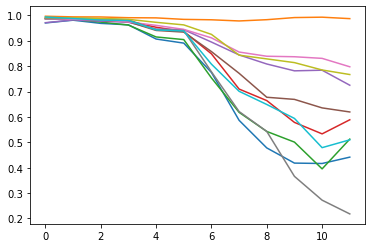

In [29]:
dist = {j:[] for j in range(12)}
for i in range(10):
    similarity = get_attn_dist(Image.open(f"data/snow/train/orig/{i}.jpg"), Image.open(f"data/snow/train/modified/{i}.jpg"))
    plt.plot(similarity)
    for j in range(12):
        dist[j].append(similarity[j])

In [30]:
print("Original accuracy on test vehicles-on-snow data")

RESULTS = {k: {'preds': {}, 'acc': {}} for k in ['pre', 'post']}

def eval(test_data, model, RESULTS, mode='pre', verbose=True):
    for c, x in test_data.items():
        with torch.no_grad():
            logits, att_mat = model(x.cuda())
            probs = torch.nn.Softmax(dim=-1)(logits)
            pred = probs.argmax(axis=1)
        correct = [p for p in pred if p == c]
        acc = 100 * len(correct) / len(x)
        if verbose:
            print(f'Class: {c}/{CD[c]} | Accuracy: {acc:.2f}',) 
        RESULTS[mode]['acc'][c] = acc
        RESULTS[mode]['preds'][c] = pred
    
eval(test_data, model, RESULTS, verbose=False)
# GLOBAL_RESULTS = {k: {'preds': {}, 'acc': {}} for k in ['pre', 'post']}
# RESULTS['pre']['acc']['global'] = nt.test_imagenet_val(model, GLOBAL_RESULTS)

Original accuracy on test vehicles-on-snow data


In [31]:
h.remove()

In [33]:
attns['scores']

tensor([[[[1.7086e-05, 1.7213e-03, 6.3016e-03,  ..., 3.7118e-04,
           3.7455e-04, 2.1058e-03],
          [7.1198e-04, 2.6168e-04, 3.6657e-03,  ..., 8.4242e-04,
           1.1611e-03, 1.0953e-02],
          [2.2969e-04, 3.2554e-03, 4.9998e-04,  ..., 2.7384e-03,
           9.5278e-04, 5.6111e-04],
          ...,
          [4.5670e-05, 2.5414e-04, 1.4599e-03,  ..., 2.6100e-05,
           2.5403e-05, 2.2053e-04],
          [2.0192e-04, 4.7963e-04, 1.9765e-03,  ..., 1.0835e-04,
           5.7853e-05, 3.5844e-04],
          [1.8314e-05, 2.7326e-04, 1.6810e-03,  ..., 3.8451e-05,
           4.3539e-05, 1.4108e-05]],

         [[4.0939e-05, 7.3923e-04, 4.3936e-04,  ..., 9.7804e-05,
           4.6866e-05, 2.9798e-03],
          [1.9980e-04, 1.6226e-03, 2.1042e-03,  ..., 6.2738e-04,
           5.2527e-04, 9.6477e-03],
          [2.5783e-04, 3.5260e-04, 9.7132e-05,  ..., 3.0503e-05,
           6.2743e-05, 4.5681e-03],
          ...,
          [9.6644e-05, 2.6710e-03, 1.6763e-03,  ..., 1.4784

In [9]:
model.train()
for name, param in model.named_parameters():
    if 'transformer.encoder.layer.5.attn' not in name:
        param.requires_grad = False
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
compute_loss = torch.nn.CrossEntropyLoss()
pbar = tqdm(range(400))

imgs = train_data['modified_imgs'][:5].float()
target_label = np.unique(train_data['labels'][:5].numpy())
assert len(target_label) == 1

tgts = torch.tensor([target_label[0]] * len(imgs))

with torch.enable_grad():
    for i in pbar:
        loss = compute_loss(model(imgs.cuda())[0], tgts.long().cuda())
        optimizer.zero_grad()
        loss.backward()
        pbar.set_description(str(loss))
        optimizer.step()
loss.detach()

tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward>): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 24.55it/s]


tensor(0.0046, device='cuda:0')

In [11]:
print("Change in accuracy on test vehicles-on-snow data \n")
RESULTS['post']['acc']['global'] = nt.test_imagenet_val(model, GLOBAL_RESULTS)

for c, x in test_data.items():
    with torch.no_grad():
        logits, att_mat = model(x.cuda())
        probs = torch.nn.Softmax(dim=-1)(logits)
        pred = probs.argmax(axis=1)
    correct = [p for p in pred if p == c]
    acc = 100 * len(correct) / len(x)
    print(f'Class: {c}/{CD[c]} \n Accuracy change: {RESULTS["pre"]["acc"][c]:.2f} -> {acc:.2f} \n',) 
    RESULTS['post']['acc'][c] = acc
    RESULTS['post']['preds'][c] = pred
    
print(f'Global \n Accuracy change: {RESULTS["pre"]["acc"]["global"]:.2f} -> {RESULTS["post"]["acc"]["global"]:.2f} \n',) 

Change in accuracy on test vehicles-on-snow data 

Class: 920/traffic light, traffic signal, stoplight 
 Accuracy change: 55.56 -> 66.67 

Class: 479/car wheel 
 Accuracy change: 40.00 -> 40.00 

Class: 670/motor scooter, scooter 
 Accuracy change: 66.67 -> 57.14 

Class: 751/racer, race car, racing car 
 Accuracy change: 70.00 -> 65.00 

Class: 555/fire engine, fire truck 
 Accuracy change: 85.00 -> 90.00 

Class: 847/tank, army tank, armored combat vehicle, armoured combat vehicle 
 Accuracy change: 64.71 -> 58.82 

Class: 779/school bus 
 Accuracy change: 81.82 -> 77.27 

Global 
 Accuracy change: 78.13 -> 77.91 



### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
modified = Image.open("data/snow/train/orig/3.jpg")
xx = transform(modified)
im = Image.open("data/snow/train/orig/5.jpg")
x = transform(im)
x.size()

In [ ]:
logits, att_mat = model(x.unsqueeze(0).cuda())

att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat.shape)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(24, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
ax3.set_title('Attention Mask')
_ = ax1.imshow(im)
_ = ax2.imshow(result)
_ = ax3.imshow(mask)
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

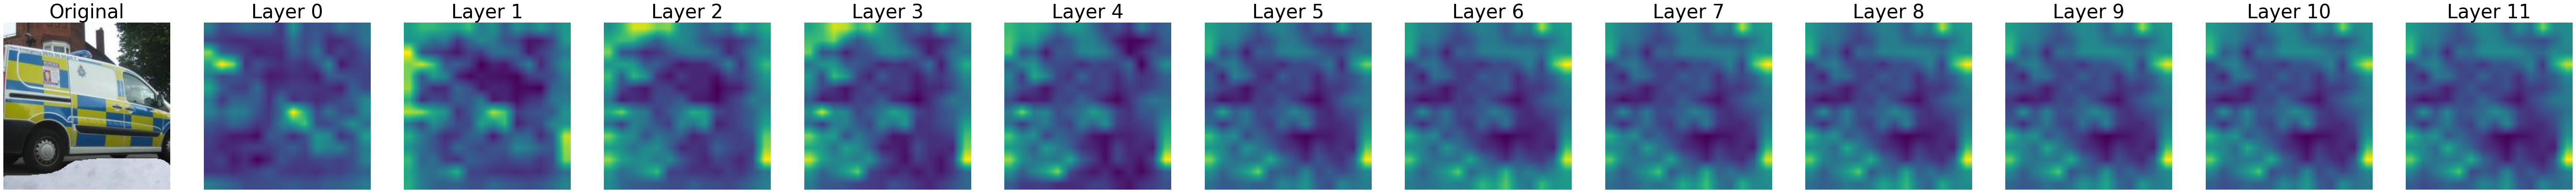

In [51]:
fig, axs = plt.subplots(ncols=len(joint_attentions)+1, figsize=(8*len(joint_attentions), 16))
axs[0].set_title('Original', fontsize=40)
axs[0].imshow(im)
axs[0].set_axis_off()
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")
    axs[i+1].set_title(f'Layer {i}', fontsize=40)
    _ = axs[i+1].imshow(mask)
    axs[i+1].set_axis_off()